In [2]:
# Importare le librerie
import tweepy
from dotenv import dotenv_values
# Importare le variabili d'ambiente dal file .env
config = dotenv_values(".env")


Definiamo le funzioni serealize_json e read_json che ci serviranno rispettivamente per salvare dati in locale e leggere file JSON da locale, servendoci delle librerie json e os.

In [3]:
# %load utils.py
import json
import os


def serealize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}.json", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}.json")


def read_json(path):
    try:
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as file:
                data = json.load(file)
            return data
    except ValueError:
        print("Path not found, check the correctness of the path")


Utilizzo la libreria Tweepy per creare un client. Esso interagirà con la Twitter API. La libreria Tweepy permette di astrarre le chiamate HTTP per interagire con la Twitter API semplificandone l'utilizzo.


Creiamo un client Tweepy utilizzando il `BREARER_TOKEN` presente nel file `.env` e caricato tramite la libreria `dotenv`.


In [4]:
# Nuovo client Tweepy
client = tweepy.Client(
    bearer_token=config["BEARER_TOKEN"], wait_on_rate_limit=True)


Creo una funzione generica get_parsed_users_followers(id) che mi restituisce un dizionario di tutti i follower di un utente e per ciascuno di essi le seguenti informazioni salvate: attributi di default, descrizione del profilo, metriche pubbliche e se l'account è protetto. 
Questa funzione verrà spesso utilizzata successivamente.

In [5]:
def get_parsed_users_followers(id):
    followers = {}
    paginator = tweepy.Paginator(client.get_users_followers, id=id, user_fields=[
                                 "public_metrics", "protected", "description"], max_results=1000, limit=5).flatten(limit=1000)
    for follower in paginator:
        found_follower = {
            'name': follower.name,
            'username': follower.username,
            'description': follower.description,
            'public_metrics': follower.public_metrics,
            "protected": follower.protected
        }
        followers[follower.id] = found_follower
    return followers


## Punto 1
Usando la libreria tweepy e la funzione get_parsed_users_followers(id) da noi definita nel punto precedente scarico tutti i follower del profilo twitter dell'utente con username @KevinRoitero, ciascuno con le seguenti informazioni: attributi di default, la descrizione del profilo, le metriche pubbliche e se l'account è protetto o no.


In [6]:
kevin = client.get_user(username="KevinRoitero", user_fields=["public_metrics", "protected", "description"]).data
followers = get_parsed_users_followers(kevin.id)

# print(f'Followers count: {len(followers)}')
serealize_json("out", "kevin", followers)


Data serialized to path: out/kevin.json


## Punto 2
Per ciascun follower del profilo di @KevinRoitero utilizziamo tweepy per scaricare il numero di tweet pubblicati durante gli ultimi 7 giorni e aggiungiamo il risultato al JSON prodotto al punto 1.

In [18]:
for id in followers:
    last_week_tweets_count = 0
    recent_tweets_count = client.get_recent_tweets_count(
        query=f"from:{followers[id]['username']} -is:retweet", granularity="day").data
    for day in recent_tweets_count or []:
        last_week_tweets_count += day["tweet_count"]
    # aggiungo alle info di follower anche last_week_tweets_count
    followers[id]['last_week_tweets_count'] = last_week_tweets_count
# Aggiungere il numero di tweets nel JSON
serealize_json("out", "kevin", followers)


Data serialized to path: out/kevin.json


## Punto 3


In [19]:
# filtro la lista di follower di kevin scegliendo solo i follower che hanno a loro volta almeno un follower e non sono protected
follower_id_filtrati = []

for id in followers:
    follower_count = followers[id]["public_metrics"]["followers_count"]
    protected = followers[id]["protected"]

    if (follower_count > 1 and protected == False):
        follower_id_filtrati.append(id)


In [ ]:
for id in follower_id_filtrati:
    sub_followers = get_parsed_users_followers(id)
    followers[id]["followers"] = sub_followers

serealize_json("out", "follower-filtrati", followers)

## Punto Pre-4
Dato che il punto 3 impega circa 2 ore per generare tutti i dati, li abbiamo salvati all'interno di un file JSON. Per leggere tale file usiamo la funzione `read_json()` 

In [7]:
followers = read_json("./out/follower-filtrati.json")

## Punto 4


In [8]:
import networkx as nx

In [9]:
def get_follower_attributes(id):
    return {
        'username': followers[id]['username'],
        'description': followers[id]['description'],
        'followers_count': followers[id]['public_metrics']['followers_count']
    }

In [10]:
graph1 = nx.DiGraph()

graph1.add_node(kevin.id,attr={
    'username': kevin.username,
    'description': kevin.description,
    'followers_count': kevin.public_metrics['followers_count']
})
for id in followers:
    graph1.add_node(id, attr=get_follower_attributes(id))


In [11]:
# Check if A follow B
def follow_check(A, B):
    follower_count = followers[B]["public_metrics"]["followers_count"]
    protected = followers[B]["protected"]

    if (follower_count > 1 and protected == False):
        if A in followers[B]["followers"]:
            return True
        return False

for A in followers:
    for B in followers:
        if follow_check(A, B):
            graph1.add_edge(A,B)


## Punto 5

In [12]:
graph2 = graph1.to_undirected()
graph2 = nx.barabasi_albert_graph(n = graph2.number_of_nodes()*2, m = 2, initial_graph=graph2)

## Punto 6

In [13]:
from pyvis.network import Network

Grafici Grafo 1

In [14]:
# Grafico interattivo
visual_graph1 = Network(height="100vh", notebook=True)
visual_graph1.barnes_hut()
visual_graph1.from_nx(graph1)
visual_graph1.show("graph1.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


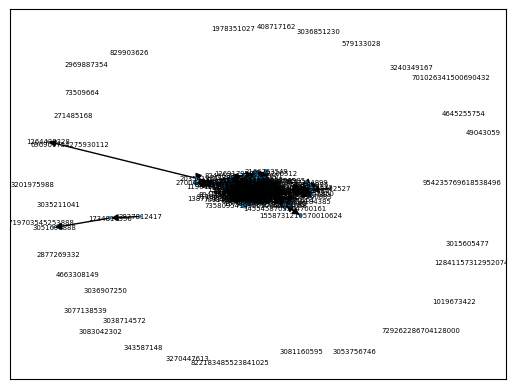

In [15]:
# Grafico static
import matplotlib.pyplot as plt
d = dict(graph1.degree)
nx.draw_networkx(
    G = graph1,
    node_size = [v for v in d.values()],
    font_size = 5,
    pos=nx.spring_layout(graph1)
)
plt.savefig("graphs/graph1.pdf")
plt.show()

Grafici Grafo 2

In [16]:
visual_graph2 = Network(height="100vh", notebook=True)
visual_graph2.barnes_hut()
visual_graph2.from_nx(graph2)
visual_graph2.show("graph2.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## Punto 7

In [20]:
nx.draw(
    graph1,
    nx.spring_layout(graph1),
    nx.degree_centrality(graph1)
)

TypeError: draw() takes from 1 to 3 positional arguments but 4 were given